# Train Pixel Classifier

This notebook trains **a single** pixel classifier model using the annotated images from the previous step, unless a previously trained model is found in the specified folder. The model is trained on the training set and evaluated on both the training and validation sets.

## Import libraries

In [ ]:
import napari
from napari.utils import nbscreenshot
from pathlib import Path
from skimage.io import imread
import napari_simpleitk_image_processing as nsitk
import numpy as np
import apoc
from natsort import natsorted
import json

from utilities import refine_labels

## 1. Inputs

In [2]:
data_path =  Path("../../data/Spheroids/")

Get list of paths of train, annotation and validation images.


In [3]:
training_set_folder_path = data_path / 'train'
validation_set_folder_path =  data_path / 'validation'
training_annotations_folder_path = data_path / 'train_annotations'
train_images_paths = natsorted([path for path in training_set_folder_path.iterdir()])
annotation_images_paths = natsorted([path for path in training_annotations_folder_path.iterdir()])
validation_images_paths = natsorted([path for path in validation_set_folder_path.iterdir()])
existing_model = False


Load min_area value from json file. This value is used to filter out small objects in the training and validation sets. If the file does not exist, it will be set to the defualt value, which is 1000.

In [4]:
# Load min_area json file, get min_area key-value par and store it in min_area variable
try:
    with open(data_path / 'min_area.json') as f:
        min_area = json.load(f)['min_area']
# Handle exception in case file is not found
except FileNotFoundError:
    print(f"Warning! 'min_area.json' file not found in {data_path}! Using default value of 1000.")
    min_area = 1000

print(f"min_area = ", min_area)


min_area =  1000


## 2. Train model on all annotated images

Derived from https://github.com/haesleinhuepf/apoc/blob/main/demo/demp_pixel_classifier_continue_training.ipynb.
First, look if a model file (except for the `temp_model.cl`) is already in the `Spheroids` folder. If it is, it will use that model instead of creating and training a new one.

If you want to train a new model, delete the existing model file in the `Spheroids` folder or move it to another folder.

In [5]:
# Define features
features = ("original gaussian_blur=0.5 difference_of_gaussian=0.5 laplace_diamond_of_gaussian_blur=0.5 difference_of_gaussian=0.5 " +\
            "gaussian_blur=1 difference_of_gaussian=1 laplace_diamond_of_gaussian_blur=1 difference_of_gaussian=1 " +\
            "gaussian_blur=2 difference_of_gaussian=2 laplace_diamond_of_gaussian_blur=2 difference_of_gaussian=2 " +\
            "gaussian_blur=5 difference_of_gaussian=5 laplace_diamond_of_gaussian_blur=5 difference_of_gaussian=5 " +\
            "gaussian_blur=10 difference_of_gaussian=10 laplace_diamond_of_gaussian_blur=10 difference_of_gaussian=10")

cl_filepath = [path for path in data_path.iterdir() if (path.suffix == '.cl') and (path.stem != 'temp_model')]
if cl_filepath:
    cl_filepath = cl_filepath[0]
    existing_model = True
    print(f"Found existing (non-test) model in Spheroids folder called '{cl_filepath.stem}'. Skipping training and using that model instead for predictions.")
else:
    print("No model found in Spheroids folder. Creating a new file ('my_model.cl') to be trained with training images and annotations.")

    # this is where the model will be saved
    cl_filepath = data_path / 'my_model.cl'
    apoc.erase_classifier(cl_filepath)
clf = apoc.PixelClassifier(opencl_filename=cl_filepath)

No model found in Spheroids folder. Creating a new file ('my_model.cl') to be trained with training images and annotations.


The cell below only trains a model if no existing model was found. The inputs are the original images and a standard deviation filtered image provided as an extra channel.

In [6]:
if existing_model == False:
    for image_path, annotations_path in zip(train_images_paths, annotation_images_paths):
        image = imread(image_path)
        annotations = imread(annotations_path)

        # Provide standard deviation filter as extra channel
        extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
        extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
        image_stack = np.stack([image, extra_channel])

        # features = apply_filters(image)
        clf.train(features, annotations, image_stack, continue_training=True)
else:
    print("Model found in folder, skipping training.")

c:\Users\mazo260d\miniforge3\envs\devbio-napari-env\lib\site-packages\apoc\_pixel_classifier.py:107: UserWarning: Cannot continue training if it wasn't trained before. Will train from scratch instead.
  warnings.warn("Cannot continue training if it wasn't trained before. Will train from scratch instead.")


## 3. Evaluate model

Below, we evaluate the model on the training and validation sets. The evaluation is done visually by the expert.

In [7]:
viewer = napari.Viewer()
for image_path in validation_images_paths:
    image = imread(image_path)
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])
    result = clf.predict(image=image_stack)
    # Post-process labels
    labels_post_processed = refine_labels(result, min_area)
    # Add images to napari viewer
    viewer.add_image(image, name=image_path.stem + '_validation_set')
    viewer.add_labels(labels_post_processed, name='Predictions of ' + image_path.stem + '_validation_set')

for image_path in train_images_paths:
    image = imread(image_path)
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])
    result = clf.predict(image=image_stack)
    # Post-process labels
    labels_post_processed = refine_labels(result, min_area)
    # Add images to napari viewer
    viewer.add_image(image, name=image_path.stem + '_training_set')
    viewer.add_labels(labels_post_processed, name='Predictions of ' + image_path.stem + '_training_set')

Assistant skips harvesting pyclesperanto as it's not installed.


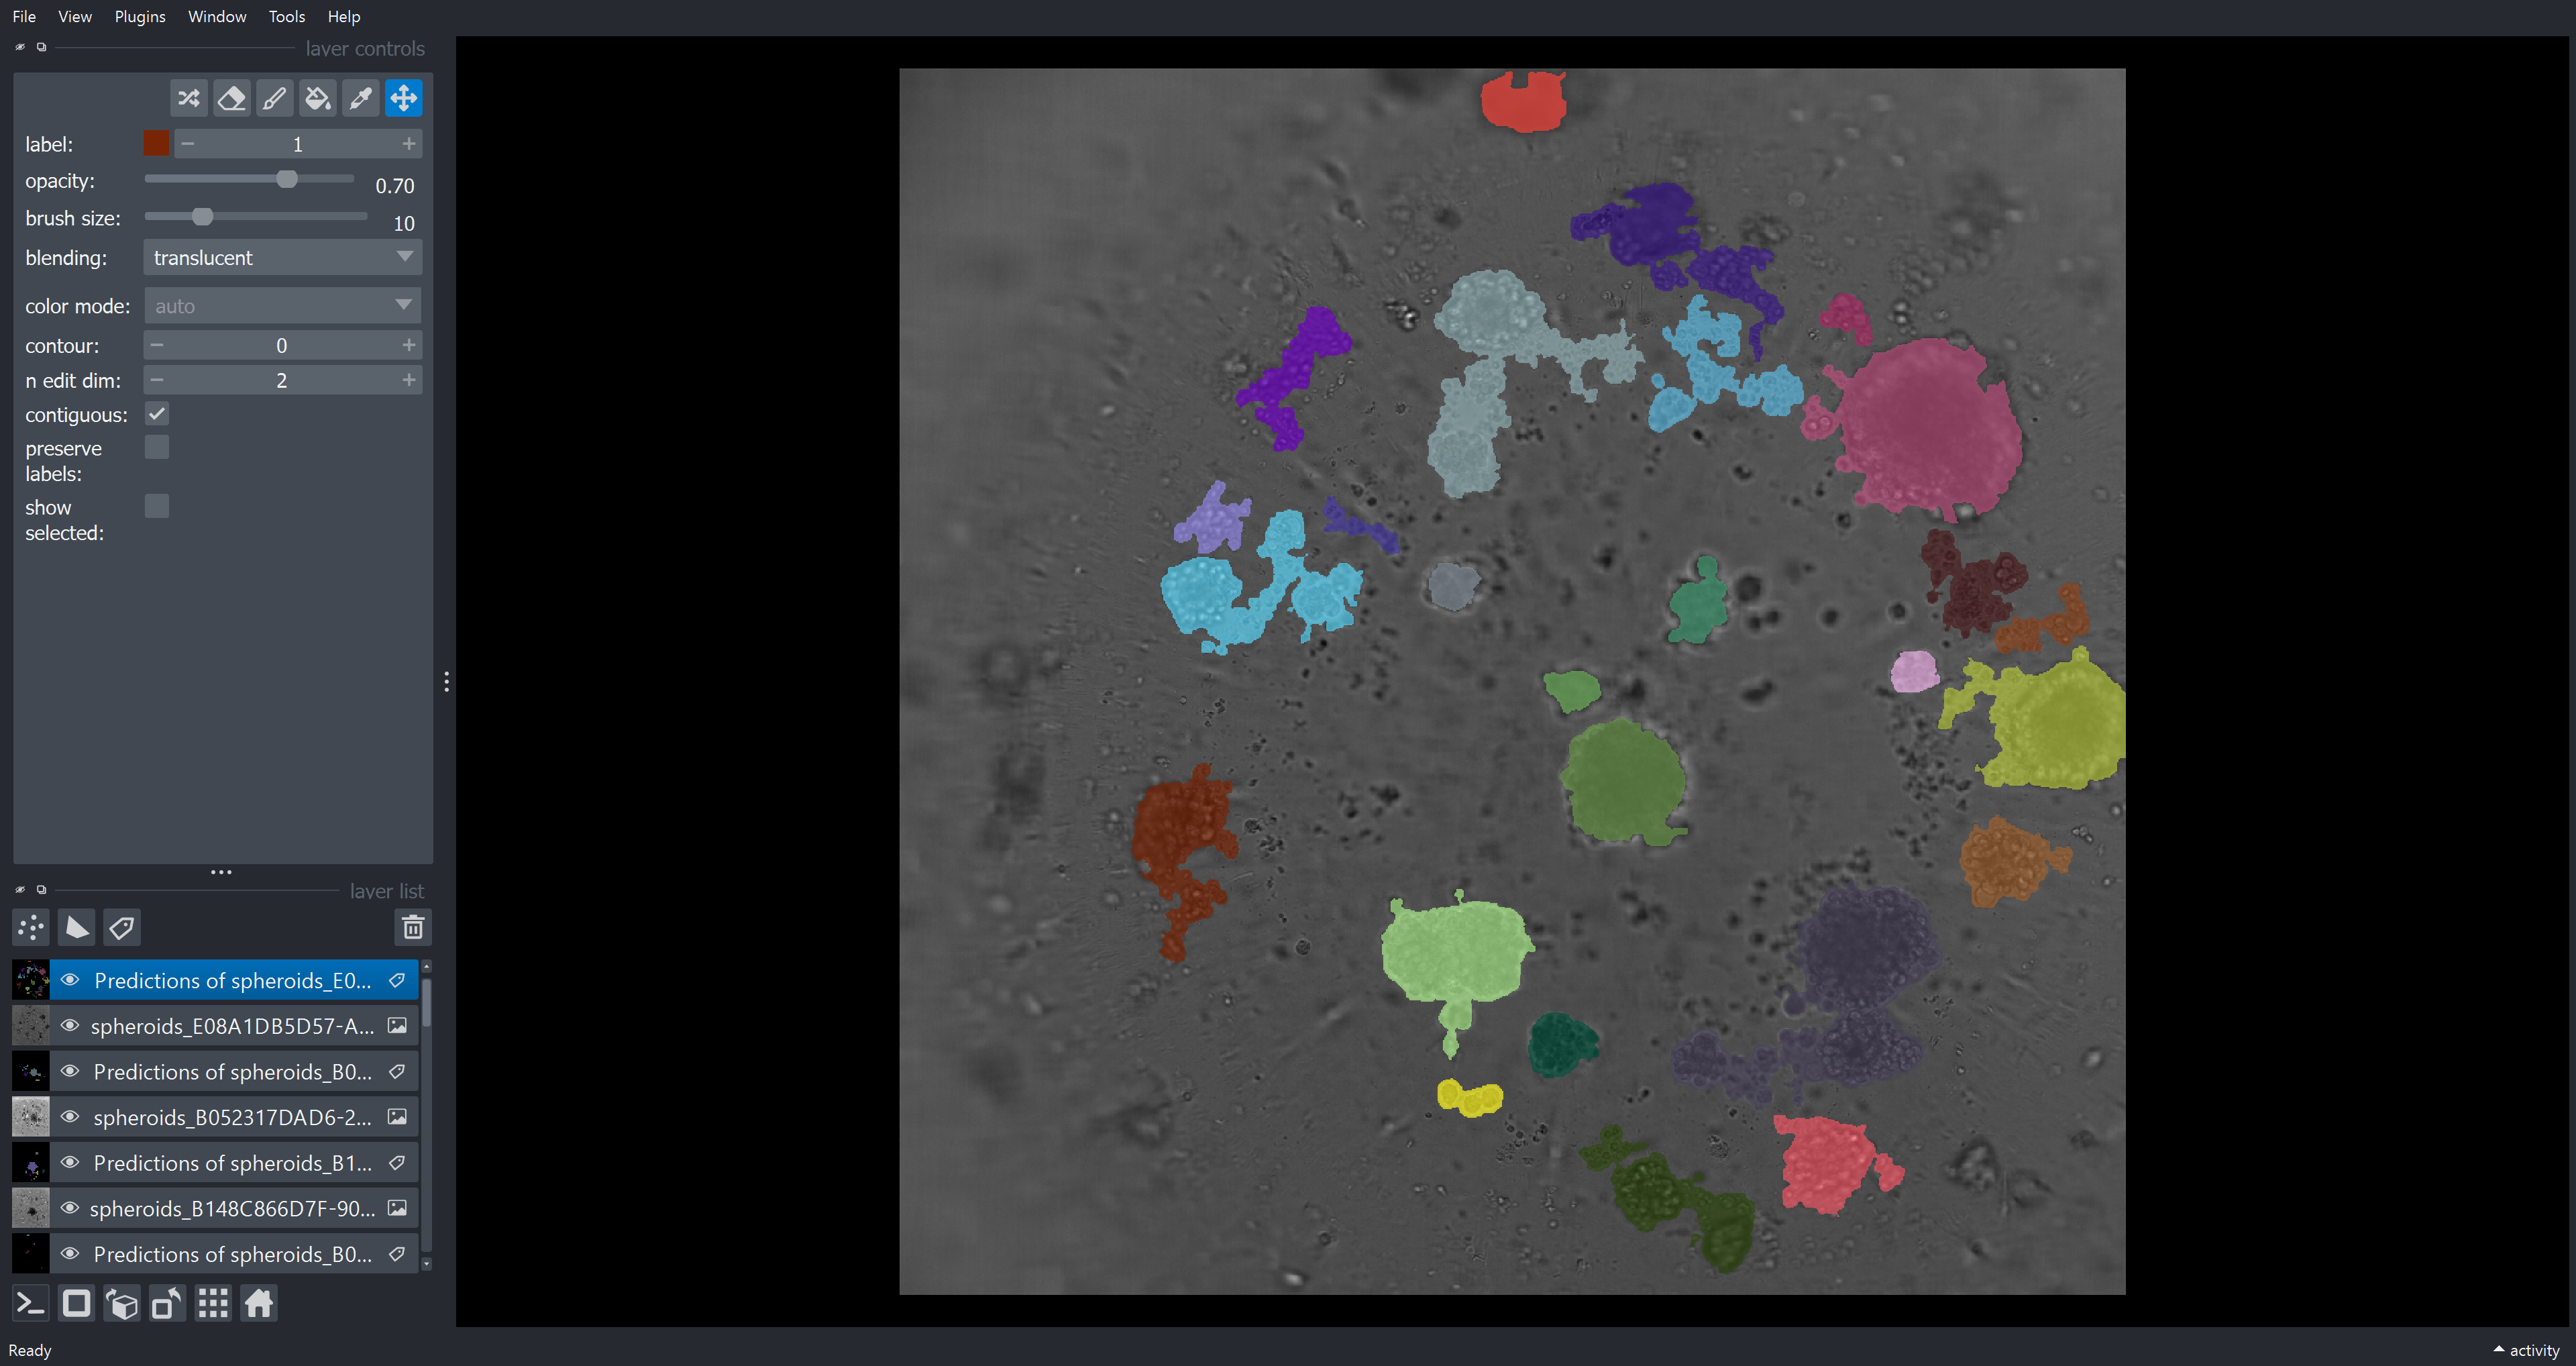

In [8]:
nbscreenshot(viewer)

If results are unsatisfactory, go back to previous notebook [1_Image_annotation](1_Image_annotation.ipynb) and provide some extra annotations.